In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker
import numpy as np
import importlib
import xarray as xr
import nc_time_axis
import cmocean
import cmocean.cm as cmo
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.patches import Patch, Polygon
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, BboxPatch, BboxConnector,\
    BboxConnectorPatch, zoomed_inset_axes, mark_inset
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import shapely.geometry as sgeom
from matplotlib.lines import Line2D as Line
from matplotlib.patheffects import Stroke
import mpl_toolkits.axes_grid1.inset_locator as il
import cv2
import glob
import nc_time_axis
from eofs.xarray import Eof
import scipy.signal as sps
import scipy.linalg as spl
from scipy import stats
from matplotlib import gridspec
from scipy.signal import butter, lfilter
from functools import partial
from matplotlib.lines import Line2D

from statsmodels.tsa.seasonal import STL
import pandas as pd
from scipy.integrate import odeint
import _pickle as cPickle
import os,sys
from matplotlib.font_manager import FontProperties
import string
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

import ultraplot as pplt

from matplotlib import patheffects

import pickle

In [2]:
mpl.rcParams['figure.dpi'] = 100

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [4]:
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [9]:
!ls variables/*.pickle

variables/prect_IND.pickle          variables/tauy_IND.pickle
variables/prect_LONLAT.pickle       variables/tauy_LONLAT.pickle
variables/prect_MEAN.pickle         variables/tauy_MEAN.pickle
variables/prect_PAC.pickle          variables/tauy_PAC.pickle
variables/prect_STD.pickle          variables/tauy_STD.pickle
variables/solin_IND.pickle          variables/temp_IND.pickle
variables/solin_LONLAT.pickle       variables/temp_LONLAT.pickle
variables/solin_MEAN.pickle         variables/temp_MEAN.pickle
variables/solin_PAC.pickle          variables/temp_PAC.pickle
variables/solin_STD.pickle          variables/temp_STD.pickle
variables/taux_IND.pickle           variables/thermocline_IND.pickle
variables/taux_LONLAT.pickle        variables/thermocline_LONLAT.pickle
variables/taux_MEAN.pickle          variables/thermocline_MEAN.pickle
variables/taux_PAC.pickle           variables/thermocline_PAC.pickle
variables/taux_STD.pickle           variables/thermocline_STD.pickle


In [5]:
directory = 'variables/'

pickle_files = [f for f in os.listdir(directory) if f.endswith('.pickle')]

data_dict = {}

for filename in pickle_files:
    file_path = os.path.join(directory, filename)

    with open(file_path, 'rb') as file:
        data = pickle.load(file)

    key = os.path.splitext(filename)[0]
    data_dict[key] = data

for key, value in data_dict.items():
    print(f'Contents of {key}:')
    print(value)
    print('---' * 20)

Contents of temp_MEAN:
{'NINO34_max': {'NINO34': {'lonlat': <xarray.DataArray 'TS' (month: 12, lat: 16, lon: 77)> Size: 59kB
array([[[296.77606, 296.79904, 296.68182, ..., 295.58563, 295.39685,
         295.328  ],
        [298.29776, 298.34372, 298.253  , ..., 296.8268 , 296.88116,
         296.95248],
        [298.79944, 298.1795 , 298.55487, ..., 297.4114 , 297.63644,
         297.78107],
        ...,
        [286.1379 , 285.5987 , 286.8694 , ..., 294.55823, 294.23245,
         293.97336],
        [283.8841 , 282.75616, 289.72357, ..., 293.78488, 293.41217,
         293.09375],
        [280.24634, 286.54276, 283.35654, ..., 292.5793 , 292.3159 ,
         292.0423 ]],

       [[297.6698 , 297.68164, 297.5941 , ..., 296.58112, 296.4589 ,
         296.46286],
        [298.721  , 298.97098, 299.02963, ..., 297.6327 , 297.82614,
         297.96674],
        [298.80237, 298.25293, 299.03842, ..., 298.08054, 298.38904,
         298.47617],
...
        [290.53482, 290.38718, 291.9061 , ...,

In [16]:
#precipitation = sel_szn(precip_cmap,mon_list=[7])  # select month of precip to choose, yearly values obtained

def calculate_centroid_latitude(precipitation):
    # Select the latitude range of 20°N to 20°S
    if precipitation.lat.values[0] > 0:
        precipitation_lat_range = precipitation.sel(lat=slice(30, -30))
    else: 
        precipitation_lat_range = precipitation.sel(lat=slice(-30, 30))

    # Compute the latitude of the ITCZ centroid for each time step and longitude
    weights = np.cos(np.deg2rad(precipitation_lat_range.lat))
    weighted_precipitation = precipitation_lat_range * weights
    sum_over_latitude = weighted_precipitation.sum(dim='lat')

    # Compute the latitude corresponding to the centroid for each time step and longitude
    centroid_latitude = (precipitation_lat_range.lat * weighted_precipitation).sum(dim='lat') / sum_over_latitude
    
    # Create an xarray Dataset with the centroid_latitude, including the longitude dimension
    centroid_latitude_dataset = xr.Dataset(
        {'centroid_latitude': centroid_latitude},
        coords={'month':precipitation.month,'lon': precipitation.lon}
    )
    
    return centroid_latitude_dataset.centroid_latitude

In [124]:
#precipitation = sel_szn(precip_cmap,mon_list=[7])  # select month of precip to choose, yearly values obtained

def calculate_centroid_latitude(precipitation):
    # Select the latitude range of 30°N to 30°S
    if precipitation.lat.values[0] > 0:
        precipitation_lat_range = precipitation.sel(lat=slice(30, -30))
        fine_lat = np.arange(30, -30.1, 0.1)
    else: 
        precipitation_lat_range = precipitation.sel(lat=slice(-30, 30))
        fine_lat = np.arange(-30, 30.1, 0.1)

    fine_lon = np.arange(45, 285+1, 1)

    # Interpolate the latitude to a finer grid (0.1° steps)
    precipitation_interpolated = precipitation_lat_range.interp(lat=fine_lat,lon=fine_lon)

    max_precipitation_lat = precipitation_interpolated.idxmax(dim='lat')

    loc_ITCZ = np.zeros_like(precipitation_interpolated.lon)

    k = 0

    for i in precipitation_interpolated.lon.values:
        #print(i)
        
        #lat_range = precipitation_interpolated.sel(lat=slice(max_precipitation_lat.sel(lon=i,method='nearest').values, 31)).sel(lon=i,method='nearest')
        lat_range = precipitation_interpolated.sel(lat=slice(-31, 31)).sel(lon=i,method='nearest')

        weighted_precipitation = lat_range * lat_range.lat
        sum_over_latitude = weighted_precipitation.sum(dim='lat')
        sum_precipitation = lat_range.sum(dim='lat')

        # print(sum_precipitation)
        # print(sum_over_latitude)

        loc_ITCZ[k] = sum_over_latitude / sum_precipitation

        k += 1

    loc_ITCZ_dataset = xr.Dataset(
        {'loc_ITCZ': (['lon'], loc_ITCZ)},
        coords={'lon': precipitation_interpolated.lon}
    )
    
    return loc_ITCZ_dataset.loc_ITCZ

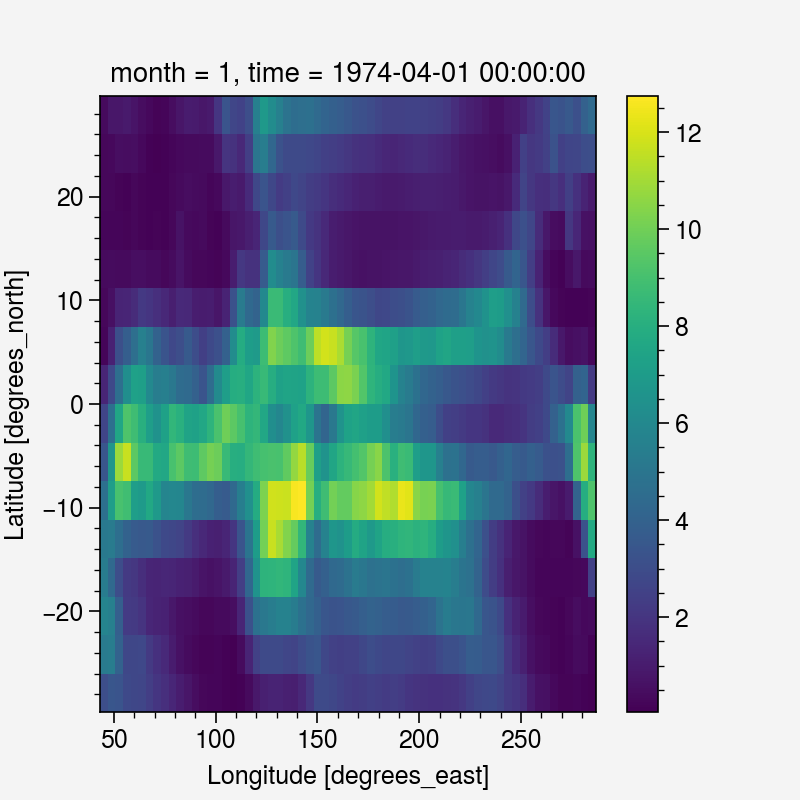

In [12]:
(data_dict['prect_LONLAT']['NINO34_max'].mn.isel(month=0)*8.64e+7 + data_dict['prect_LONLAT']['NINO34_max']['yr_mn']*8.64e+7).plot()

In [8]:
data_dict['prect_LONLAT']['NINO34_max']

<xarray.Dataset> Size: 63kB
Dimensions:  (lon: 65, lat: 16, month: 4)
Coordinates:
  * lon      (lon) float64 520B 45.0 48.75 52.5 56.25 ... 277.5 281.2 285.0
  * lat      (lat) float64 128B -27.83 -24.12 -20.41 -16.7 ... 20.41 24.12 27.83
  * month    (month) int64 32B 1 2 3 4
    time     object 8B 1974-04-01 00:00:00
Data variables:
    mn       (month, lat, lon) float32 17kB 7.285e-09 8.431e-09 ... 1.138e-08
    mask     (month, lat, lon) int64 33kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    yr_mn    (lat, lon) float32 4kB 2.807e-08 3.164e-08 ... 4.262e-08 4.723e-08
    yr_mask  (lat, lon) int64 8kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [94]:
data_dict['prect_LONLAT']['NINO34_max']['yr_mn'].lon

<xarray.DataArray 'lon' (lon: 65)> Size: 520B
array([ 45.  ,  48.75,  52.5 ,  56.25,  60.  ,  63.75,  67.5 ,  71.25,  75.  ,
        78.75,  82.5 ,  86.25,  90.  ,  93.75,  97.5 , 101.25, 105.  , 108.75,
       112.5 , 116.25, 120.  , 123.75, 127.5 , 131.25, 135.  , 138.75, 142.5 ,
       146.25, 150.  , 153.75, 157.5 , 161.25, 165.  , 168.75, 172.5 , 176.25,
       180.  , 183.75, 187.5 , 191.25, 195.  , 198.75, 202.5 , 206.25, 210.  ,
       213.75, 217.5 , 221.25, 225.  , 228.75, 232.5 , 236.25, 240.  , 243.75,
       247.5 , 251.25, 255.  , 258.75, 262.5 , 266.25, 270.  , 273.75, 277.5 ,
       281.25, 285.  ])
Coordinates:
  * lon      (lon) float64 520B 45.0 48.75 52.5 56.25 ... 277.5 281.2 285.0
    time     object 8B 1974-04-01 00:00:00
Attributes:
    name:               lon
    long_name:          Longitude
    units:              degrees_east
    axis:               X
    standard_name:      longitude
    coodinate_defines:  gridcell_center

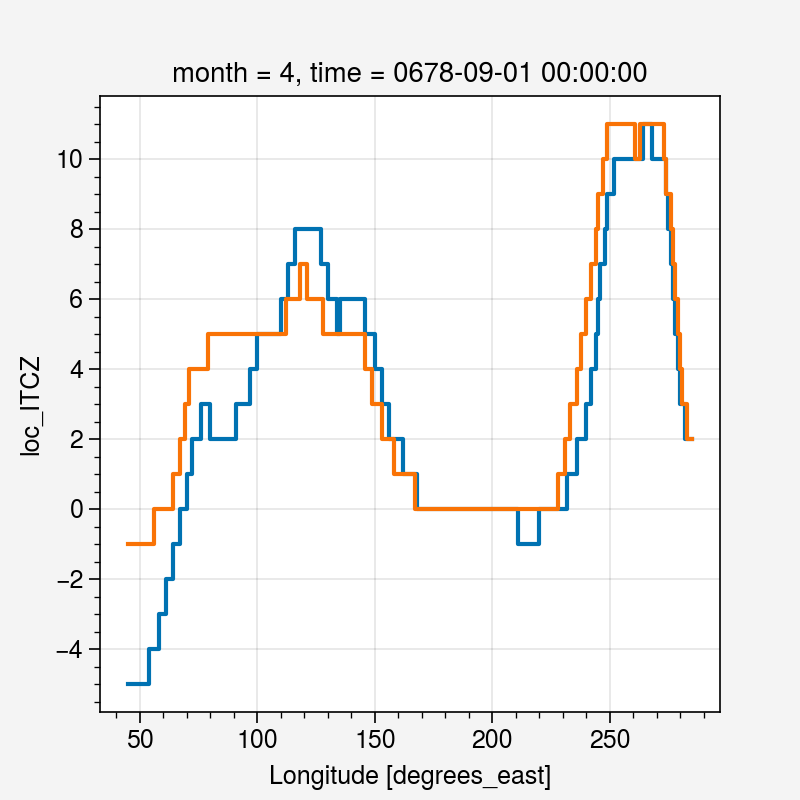

In [125]:
calculate_centroid_latitude((data_dict['prect_LONLAT']['NINO34_max'].mn.isel(month=3)*8.64e+7 + data_dict['prect_LONLAT']['NINO34_max']['yr_mn']*8.64e+7)).plot.step()
calculate_centroid_latitude((data_dict['prect_LONLAT']['DMI_max'].mn.isel(month=3)*8.64e+7 + data_dict['prect_LONLAT']['DMI_max']['yr_mn']*8.64e+7)).plot.step(color='orange')

In [126]:
calculate_centroid_latitude((data_dict['prect_LONLAT']['DMI_max'].mn.isel(month=3)*8.64e+7 + data_dict['prect_LONLAT']['DMI_max']['yr_mn']*8.64e+7)).mean()

<xarray.DataArray 'loc_ITCZ' ()> Size: 8B
array(3.593361)
Coordinates:
    month    int64 8B 4
    time     object 8B 0678-09-01 00:00:00

In [127]:
calculate_centroid_latitude((data_dict['prect_LONLAT']['NINO34_max'].mn.isel(month=3)*8.64e+7 + data_dict['prect_LONLAT']['NINO34_max']['yr_mn']*8.64e+7)).mean()


<xarray.DataArray 'loc_ITCZ' ()> Size: 8B
array(2.87966805)
Coordinates:
    month    int64 8B 4
    time     object 8B 1974-04-01 00:00:00

(-2.0, 5.0)

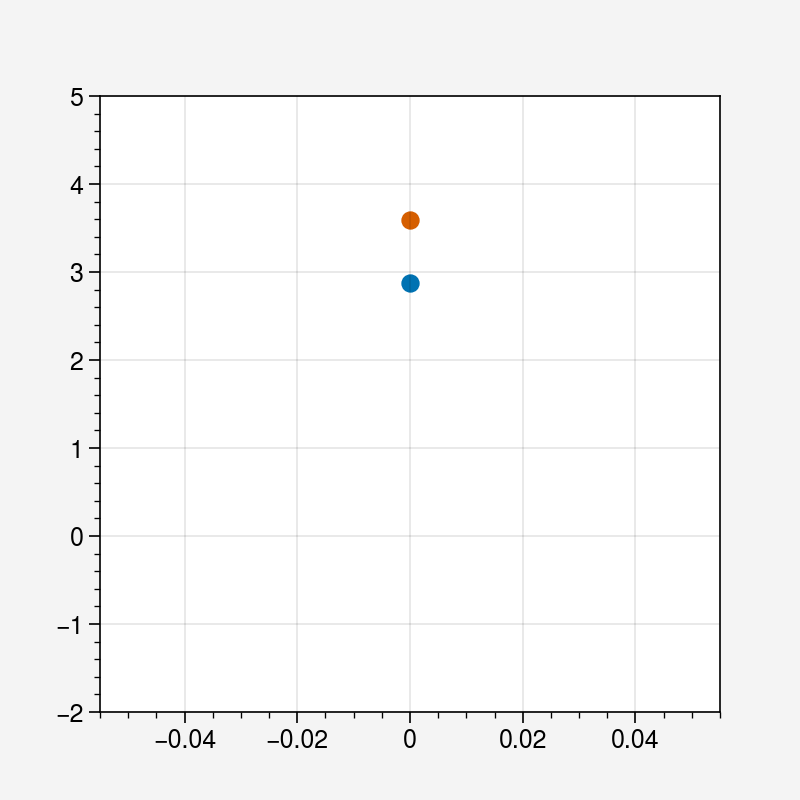

In [131]:
plt.scatter(0,calculate_centroid_latitude((data_dict['prect_LONLAT']['NINO34_max'].mn.isel(month=3)*8.64e+7 + data_dict['prect_LONLAT']['NINO34_max']['yr_mn']*8.64e+7)).mean())
plt.scatter(0,calculate_centroid_latitude((data_dict['prect_LONLAT']['DMI_max'].mn.isel(month=3)*8.64e+7 + data_dict['prect_LONLAT']['DMI_max']['yr_mn']*8.64e+7)).mean())

plt.ylim(-2,5)

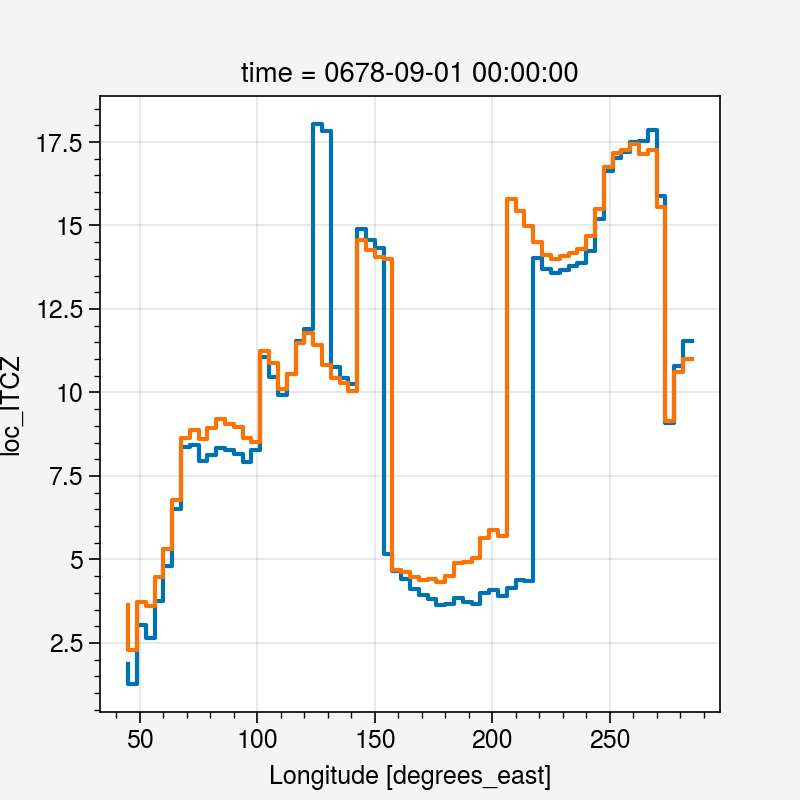

In [78]:
calculate_centroid_latitude(data_dict['prect_LONLAT']['NINO34_max']['yr_mn']*8.64e+7).plot.step()
calculate_centroid_latitude(data_dict['prect_LONLAT']['DMI_max']['yr_mn']*8.64e+7).plot.step(color='orange')

<xarray.DataArray 'month' ()> Size: 8B
array(1)
Coordinates:
    month    int64 8B 1
    time     object 8B 1974-04-01 00:00:00


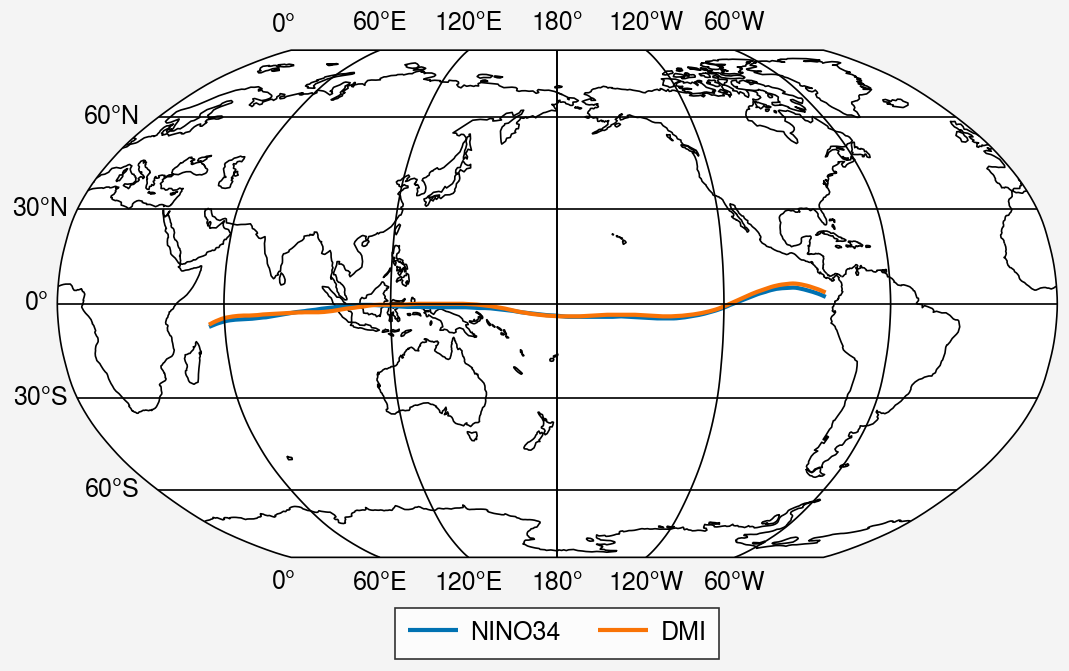


<xarray.DataArray 'month' ()> Size: 8B
array(2)
Coordinates:
    month    int64 8B 2
    time     object 8B 1974-04-01 00:00:00


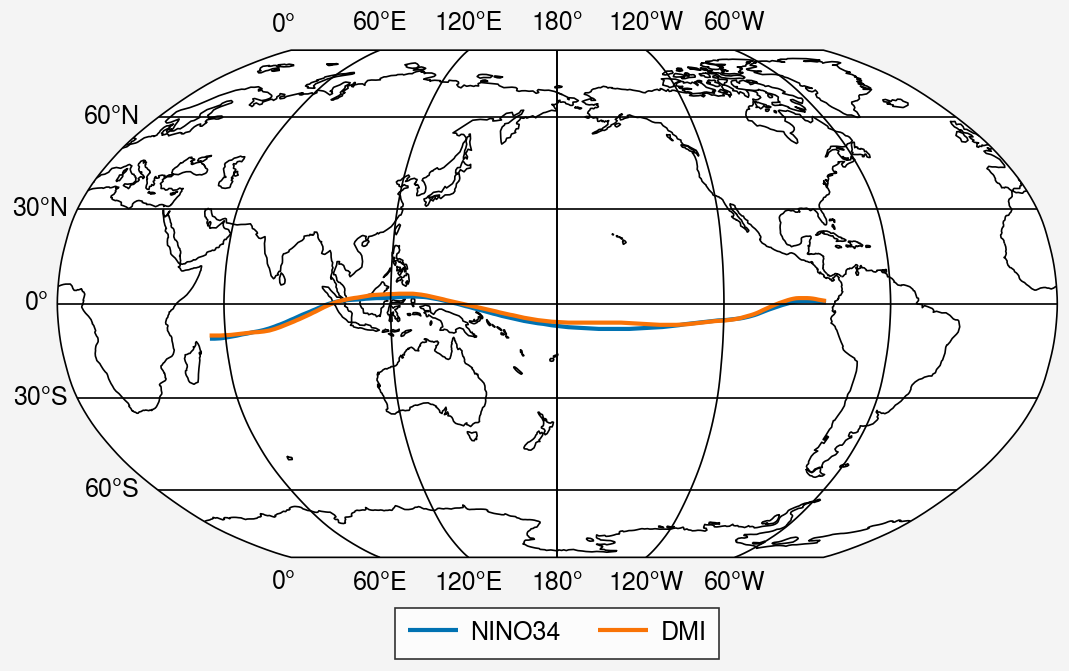


<xarray.DataArray 'month' ()> Size: 8B
array(3)
Coordinates:
    month    int64 8B 3
    time     object 8B 1974-04-01 00:00:00


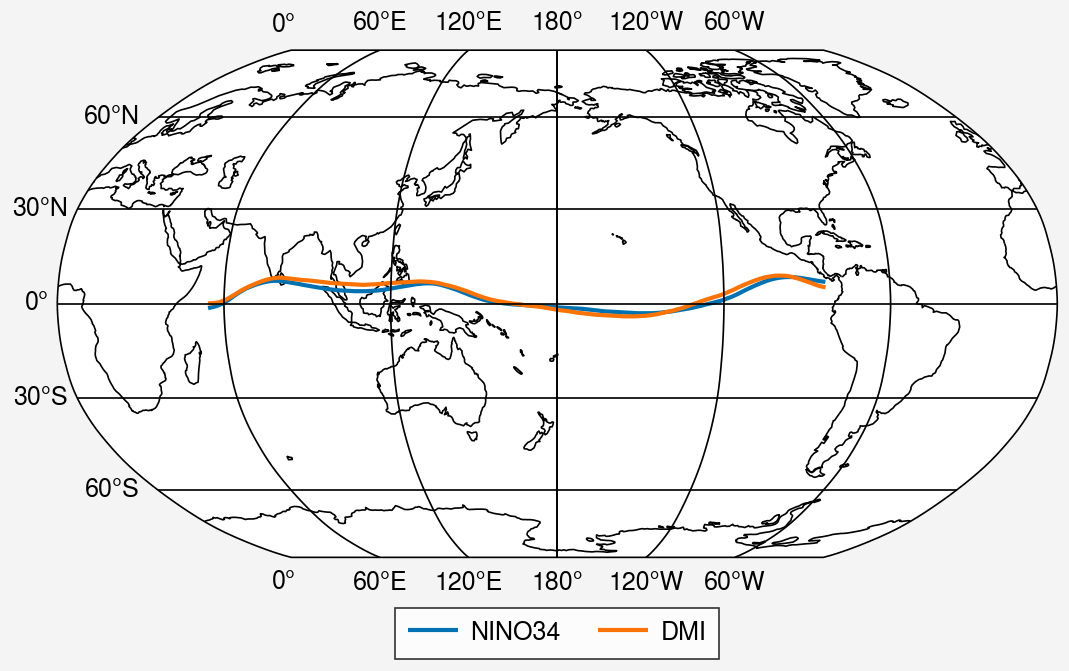


<xarray.DataArray 'month' ()> Size: 8B
array(4)
Coordinates:
    month    int64 8B 4
    time     object 8B 1974-04-01 00:00:00


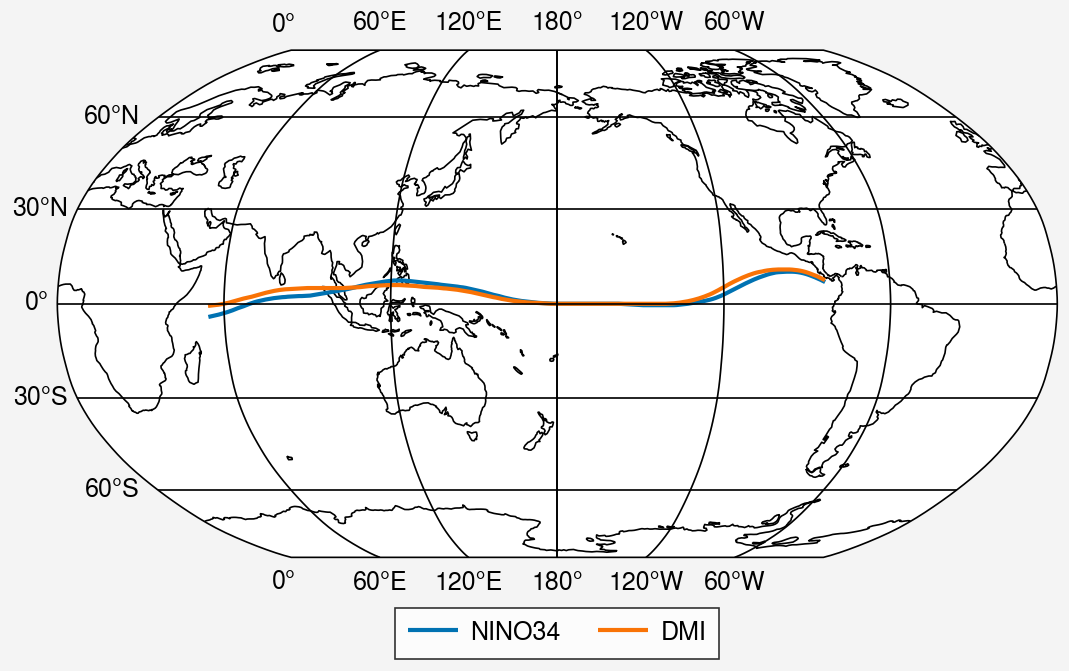

In [132]:
for i in data_dict['prect_LONLAT']['NINO34_max']['mn'].month:

    print(i)

    fig, ax = pplt.subplots(proj='robin', proj_kw={'lon_0': 180},refwidth=5)

    # itcz_nino34 = calculate_centroid_latitude(data_dict['prect_LONLAT']['NINO34_max']['yr_mn']*8.64e+7)
    # itcz_dmi = calculate_centroid_latitude(data_dict['prect_LONLAT']['DMI_max']['yr_mn']*8.64e+7)

    itcz_nino34 = calculate_centroid_latitude(data_dict['prect_LONLAT']['NINO34_max']['yr_mn']*8.64e+7 + \
        data_dict['prect_LONLAT']['NINO34_max']['mn'].sel(month=i)*8.64e+7).rolling(lon=20, center=True).mean()
    itcz_dmi = calculate_centroid_latitude(data_dict['prect_LONLAT']['DMI_max']['yr_mn']*8.64e+7 + \
        data_dict['prect_LONLAT']['DMI_max']['mn'].sel(month=i)*8.64e+7).rolling(lon=20, center=True).mean()

    # Plot the ITCZ locations
    ax.plot(itcz_nino34.lon, itcz_nino34, label='NINO34', transform=ccrs.PlateCarree())
    ax.plot(itcz_dmi.lon, itcz_dmi, label='DMI', color='orange', transform=ccrs.PlateCarree())

    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Add a legend
    ax.legend(loc='b')

    # Show the plot
    pplt.show()

    print('')